In [1]:
import argparse
import torch
import yaml
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from cxrclip import build_model
from cxrclip.loss import build_loss
from data import load_tokenizer
from cxrclip.pretrain import CXRCLIPTrainer
from cxrclip.finetune import CXRClassifierTrainer
from data.loaders import CxrDataLoader
from constants import CHEXPERT_LABELS

/Users/tudormihaita/PycharmProjects/clip-cxr-report-gen/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
tokenizer_config = yaml.load(open("../configs/tokenizer/clinical_bert.yaml"), Loader=yaml.FullLoader)
tokenizer = load_tokenizer(**tokenizer_config)

/Users/tudormihaita/PycharmProjects/clip-cxr-report-gen/.venv/lib/python3.9/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
# model_config = yaml.load(open("../configs/model/clip_swin_clinical.yaml"), Loader=yaml.FullLoader)
model_config = yaml.load(open("../configs/model/swin_classification.yaml"), Loader=yaml.FullLoader)
# loss_config = yaml.load(open("../configs/loss/contrastive.yaml"), Loader=yaml.FullLoader)
loss_config = yaml.load(open("../configs/loss/classification.yaml"), Loader=yaml.FullLoader)
model = build_model(model_config, loss_config, tokenizer, use_custom=True)
loss_fn = build_loss(loss_config)

2025-05-13 22:36:52,384 - INFO - loading pre-trained image encoder for fine-tuning


{'source': 'huggingface', 'name': 'microsoft/swin-tiny-patch4-window7-224', 'pretrained': True, 'model_type': 'swin'}


Some weights of the model checkpoint at microsoft/swin-tiny-patch4-window7-224 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
2025-05-13 22:36:53,713 - INFO -     freezing image encoder to not be trained


In [4]:
# checkpoint_path = "./output/swint_mc.tar"
checkpoint_path = "./output/cxr_clip_best_retrieval.pt"
checkpoint = torch.load(checkpoint_path, map_location="cpu", weights_only=False)
# model.load_state_dict(checkpoint["model_state_dict"])
print(checkpoint["model_state_dict"].keys())

odict_keys(['logit_scale', 'image_encoder.image_encoder.embeddings.patch_embeddings.projection.weight', 'image_encoder.image_encoder.embeddings.patch_embeddings.projection.bias', 'image_encoder.image_encoder.embeddings.norm.weight', 'image_encoder.image_encoder.embeddings.norm.bias', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.layernorm_before.weight', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.layernorm_before.bias', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.relative_position_bias_table', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.relative_position_index', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.query.weight', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.query.bias', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.key.weight', 'image_encoder.image_encoder.encoder.layers.0.blocks.0.attention.self.key.bias', 'image_encoder.image_encod

In [4]:
train_config = yaml.load(open("../configs/train/classification.yaml"), Loader=yaml.FullLoader)
transform_config = yaml.load(open("../configs/transform/clahe.yaml"), Loader=yaml.FullLoader)
args = argparse.Namespace(
    dataset_name='mimic-cxr-mvs',
    batch_size=10,
    max_length=train_config["max_length"],
    image_size=train_config["image_size"],
    num_workers=0,
    drop_last=True,
    use_minio=False
)

In [5]:
dataloaders = {
    "train": CxrDataLoader(
        args,
        split='train',
        transform_config=transform_config,
        tokenizer=tokenizer,
    ),
    "val": CxrDataLoader(
        args,
        split='val',
        transform_config=transform_config,
        tokenizer=tokenizer,
    ),
    "test": CxrDataLoader(
        args,
        split='test',
        transform_config=transform_config,
        tokenizer=tokenizer,
    ),
}

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tudormihaita/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tudormihaita/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/tudormihaita/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [6]:
trainer = CXRCLIPTrainer(
    model=model,
    config=train_config,
    loss_fn=loss_fn,
    train_loader=dataloaders["train"],
    val_loader=dataloaders["val"],
    test_loader=dataloaders["test"],
    mixed_precision=False
)

2025-05-13 22:37:03,596 - INFO - Total parameters: 27,530,120
2025-05-13 22:37:03,596 - INFO - Trainable parameters: 10,766 (0.04%)


In [7]:
trainer = CXRClassifierTrainer(
    model=model,
    config=train_config,
    loss_fn=loss_fn,
    train_loader=dataloaders["train"],
    val_loader=dataloaders["val"],
    mixed_precision=False
)

2025-05-13 22:37:07,913 - INFO - Total parameters: 27,530,120
2025-05-13 22:37:07,913 - INFO - Trainable parameters: 10,766 (0.04%)


In [8]:
trainer.train()

2025-05-13 22:37:11,046 - INFO - Start training
2025-05-13 22:37:11,047 - INFO - Starting epoch 1/10
Epoch 1/10:   0%|          | 8/21342 [00:04<2:58:31,  1.99it/s]


KeyboardInterrupt: 

In [10]:
model = model.eval()
batch = next(iter(dataloaders["test"]))
text_tokens, images = batch['text_tokens'], batch['images']

text_features = model.encode_text(text_tokens)
text_embeddings = model.text_projection(text_features) if model.projection else text_features
text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

image_features = model.encode_image(images.to("cpu"))
image_embeddings = model.image_projection(image_features) if model.projection else image_features
image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)

logit_scale = model.logit_scale.exp() if hasattr(model, "logit_scale") else 1.0
img_emb_np = image_embeddings.detach().cpu().numpy()
txt_emb_np = text_embeddings.detach().cpu().numpy()
print(img_emb_np)
print('--'*50)
print(txt_emb_np)
similarity = cosine_similarity(img_emb_np, txt_emb_np)

[[ 0.0061316  -0.03746258 -0.00552692 ... -0.01597597  0.07104068
  -0.03430329]
 [ 0.02979386 -0.04889434 -0.01376592 ... -0.0347896   0.05679735
  -0.02712028]
 [-0.00903004 -0.00236584 -0.08991247 ... -0.01014688  0.05448613
  -0.05474591]
 ...
 [ 0.03245471 -0.08994813 -0.01800193 ... -0.00027211  0.05864318
  -0.02993914]
 [ 0.02253014 -0.07069562 -0.04279006 ... -0.01310391  0.05557358
  -0.05665778]
 [ 0.0310822  -0.11205779 -0.05171361 ... -0.02917441  0.0460053
  -0.02591157]]
----------------------------------------------------------------------------------------------------
[[-2.0598393e-02  4.1717660e-02 -3.4079753e-02 ...  2.0395651e-02
   7.7168327e-03 -6.0038403e-02]
 [ 3.3757053e-02  7.2506763e-02 -2.5970119e-03 ...  3.3731177e-02
   3.7059452e-02 -2.5211286e-02]
 [-2.2289025e-02 -6.4187758e-03 -7.3471136e-02 ... -1.7377814e-02
   2.3404310e-02 -3.8375787e-02]
 ...
 [ 3.0994809e-06 -1.5908055e-02 -5.4595426e-02 ... -5.0807994e-02
   3.0702025e-02 -5.8977563e-02]
 [ 3.09

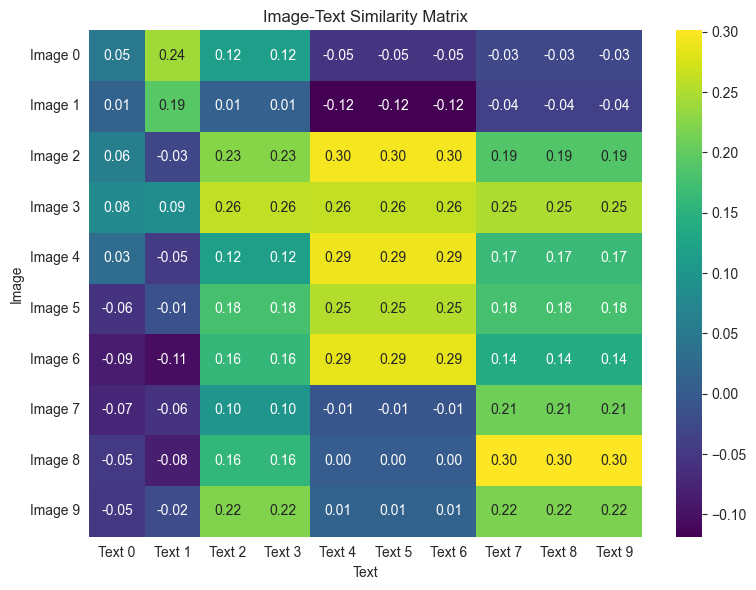

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# similarity_np = similarity.detach().cpu().numpy()
similarity_np = similarity

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_np, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=[f"Text {i}" for i in range(similarity_np.shape[1])],
            yticklabels=[f"Image {i}" for i in range(similarity_np.shape[0])])
plt.title("Image-Text Similarity Matrix")
plt.xlabel("Text")
plt.ylabel("Image")
plt.tight_layout()
plt.show()

In [12]:
images, labels = batch['images'], batch['labels']

# Class names
class_names = CHEXPERT_LABELS # Replace with your class names

# Create positive and negative prompts
negative_prompts = [f"No {cls_name}" for cls_name in class_names]
positive_prompts = [cls_name for cls_name in class_names]
all_prompts = []
for neg, pos in zip(negative_prompts, positive_prompts):
    all_prompts.extend([neg, pos])

# Get text embeddings
with torch.no_grad():
    text_tokens = tokenizer(all_prompts, padding="max_length", truncation=True,
                          max_length=256, return_tensors="pt").to("cpu")
    text_features = model.encode_text(text_tokens)
    text_embeddings = model.text_projection(text_features) if hasattr(model, "projection") and model.projection else text_features
    text_embeddings = text_embeddings / text_embeddings.norm(dim=1, keepdim=True)

    # Get image embeddings
    image_features = model.encode_image(images.to("cpu"))
    image_embeddings = model.image_projection(image_features) if hasattr(model, "projection") and model.projection else image_features
    image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)

    similarity = torch.matmul(image_embeddings, text_embeddings.T) * logit_scale

    # Extract probabilities for each class
    predictions = torch.zeros(len(images), len(class_names), device="cpu")
    for i, class_name in enumerate(class_names):
        neg_idx = i * 2
        pos_idx = i * 2 + 1

        # Get similarities for this class
        class_similarities = similarity[:, [neg_idx, pos_idx]]

        # Apply softmax to get probabilities
        class_probs = torch.nn.functional.softmax(class_similarities, dim=1)

        # Store positive class probability
        predictions[:, i] = class_probs[:, 1]

predictions = predictions.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()
# Display results for the first few samples
for i in range(min(5, len(images))):
    print(f"\nSample {i+1}:")
    print(f"Ground truth: {labels[i]}")
    print(f"Predictions:")
    for j, cls_name in enumerate(class_names):
        print(f"  {cls_name}: {predictions[i, j]:.4f}")


Sample 1:
Ground truth: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
Predictions:
  Atelectasis: 0.2347
  Cardiomegaly: 0.1078
  Consolidation: 0.2522
  Edema: 0.1184
  Enlarged Cardiomediastinum: 0.8129
  Fracture: 0.0734
  Lung Lesion: 0.5827
  Lung Opacity: 0.4689
  No Finding: 0.3402
  Pleural Effusion: 0.1040
  Pleural Other: 0.0649
  Pneumonia: 0.3271
  Pneumothorax: 0.3778
  Support Devices: 0.9201

Sample 2:
Ground truth: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
Predictions:
  Atelectasis: 0.1303
  Cardiomegaly: 0.0438
  Consolidation: 0.1969
  Edema: 0.1146
  Enlarged Cardiomediastinum: 0.8191
  Fracture: 0.1104
  Lung Lesion: 0.6475
  Lung Opacity: 0.2736
  No Finding: 0.3511
  Pleural Effusion: 0.1278
  Pleural Other: 0.0750
  Pneumonia: 0.3242
  Pneumothorax: 0.3802
  Support Devices: 0.9011

Sample 3:
Ground truth: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Predictions:
  Atelectasis: 0.6964
  Cardiomegaly: 0.6401
  Consolidation: 0.0514
  Edema: 0.1649
  Enlarged Card

In [13]:
images, labels = batch['images'], batch['labels']
class_names = CHEXPERT_LABELS

# Generate prompts
prompt_pairs = [(f"No {cls}", cls) for cls in class_names]
all_prompts = [prompt for pair in prompt_pairs for prompt in pair]  # Flatten

with torch.no_grad():
    # Tokenize prompts
    text_tokens = tokenizer(all_prompts, padding="max_length", truncation=True,
                            max_length=256, return_tensors="pt").to(images.device)
    text_features = model.encode_text(text_tokens)
    text_embeddings = model.text_projection(text_features) if hasattr(model, "projection") and model.projection else text_features
    text_embeddings = text_embeddings / text_embeddings.norm(dim=1, keepdim=True)

    # Encode images
    image_features = model.encode_image(images)
    image_embeddings = model.image_projection(image_features) if hasattr(model, "projection") and model.projection else image_features
    image_embeddings = image_embeddings / image_embeddings.norm(dim=1, keepdim=True)

    # Compute similarity scores
    similarity = torch.matmul(image_embeddings, text_embeddings.T) * logit_scale

    predictions = torch.zeros(len(images), len(class_names), device=images.device)
    for i, (neg_prompt, pos_prompt) in enumerate(prompt_pairs):
        neg_idx, pos_idx = i * 2, i * 2 + 1
        class_sim = similarity[:, [neg_idx, pos_idx]]  # (B, 2)
        class_probs = torch.nn.functional.softmax(class_sim, dim=1)
        predictions[:, i] = class_probs[:, 1]  # Probability of positive class

# Detach for logging
predictions = predictions.cpu().numpy()
labels = labels.cpu().numpy()

# Display results
for i in range(min(5, len(images))):  # Show first 5 samples
    print(f"\nSample {i+1}:")
    for j, cls in enumerate(class_names):
        print(f"  [{cls}]")
        print(f"    Ground truth: {labels[i, j]}")
        print(f"    Prompts: 'No {cls}' vs '{cls}'")
        print(f"    Predicted prob of presence: {predictions[i, j]:.4f}")


Sample 1:
  [Atelectasis]
    Ground truth: 0.0
    Prompts: 'No Atelectasis' vs 'Atelectasis'
    Predicted prob of presence: 0.2347
  [Cardiomegaly]
    Ground truth: 0.0
    Prompts: 'No Cardiomegaly' vs 'Cardiomegaly'
    Predicted prob of presence: 0.1078
  [Consolidation]
    Ground truth: 0.0
    Prompts: 'No Consolidation' vs 'Consolidation'
    Predicted prob of presence: 0.2522
  [Edema]
    Ground truth: 0.0
    Prompts: 'No Edema' vs 'Edema'
    Predicted prob of presence: 0.1184
  [Enlarged Cardiomediastinum]
    Ground truth: 0.0
    Prompts: 'No Enlarged Cardiomediastinum' vs 'Enlarged Cardiomediastinum'
    Predicted prob of presence: 0.8129
  [Fracture]
    Ground truth: 0.0
    Prompts: 'No Fracture' vs 'Fracture'
    Predicted prob of presence: 0.0734
  [Lung Lesion]
    Ground truth: 0.0
    Prompts: 'No Lung Lesion' vs 'Lung Lesion'
    Predicted prob of presence: 0.5827
  [Lung Opacity]
    Ground truth: 0.0
    Prompts: 'No Lung Opacity' vs 'Lung Opacity'
    Pr